# **Segmentation de la Clientèle d'un Centre Commercial**

## Objectif  
Utiliser les données clients pour identifier les segments les plus pertinents à cibler dans une stratégie marketing.  

## Données Disponibles  
Les informations proviennent des cartes de fidélité et incluent :  
- **Customer ID** (identifiant unique)  
- **Age**  
- **Gender** (Male/Female)  
- **Annual Income**  
- **Spending Score** ( de 1 à 100)  

> **Note** : Le *Spending Score* est calculé à partir du comportement d'achat (fréquence, montant, etc.) et de critères définis par l'entreprise.  

## Méthodologie  
1. **Analyse exploratoire** : Visualisation des distributions (âge, revenu, score).  
2. **Clustering** : Utilisation d'algorithmes (ex: K-means) pour regrouper les clients similaires.  
3. **Interprétation** : Profilage des segments (ex: "Jeunes à fort potentiel", "Clients fidèles mais économes").  

## Résultats Attendus  
- Identification de 3 à 5 segments clients.  
- Recommandations marketing pour chaque segment (ex: offres personnalisées).  


# **Vérification et téléchargement du fichier Mall_Customers.csv**

In [ ]:
# Télécharger automatiquement le fichier s’il n’existe pas
import os

FICHIER_A_SAUVEGARDER = "Mall_Customers.csv"
GITHUB_USER = "zikoelj"
GITHUB_REPO = "colab-backup"
BRANCHE = "main"

if not os.path.exists(FICHIER_A_SAUVEGARDER):
    url_fichier = f"https://raw.githubusercontent.com/{GITHUB_USER}/{GITHUB_REPO}/{BRANCHE}/{FICHIER_A_SAUVEGARDER}"
    print(f"Téléchargement automatique de {FICHIER_A_SAUVEGARDER} depuis GitHub...")
    !wget {url_fichier} -O {FICHIER_A_SAUVEGARDER}
else:
    print(f"Fichier déjà présent localement : {FICHIER_A_SAUVEGARDER}")

Fichier déjà présent localement : Mall_Customers.csv


# **1. Import des Libraries**

In [ ]:
# Importer les bibliothèques nécessaires
import numpy as np  # Calcul numérique
import pandas as pd  # Manipulation de données
import matplotlib.pyplot as plt  # Visualisation
import seaborn as sns  # Visualisation statistique
from scipy import stats  # Statistiques

# Ingénierie des caractéristiques (Feature Engineering)
from sklearn.compose import ColumnTransformer  # Transformation de colonnes
from sklearn.pipeline import Pipeline  # Création de pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Normalisation et encodage

# Modélisation
from sklearn.cluster import KMeans  # Algorithme K-means
from sklearn.cluster import DBSCAN  # Algorithme DBSCAN
from sklearn.mixture import GaussianMixture  # Modèles de mélange gaussiens
from sklearn.neighbors import NearestNeighbors  # Plus proches voisins

# Métriques d'évaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Scores de qualité des clusters

# **2. Chargement du Dataset**

In [ ]:
# charger le dataset
customer_data = pd.read_csv("Mall_Customers.csv")

# afficher les 5 premiers lignes
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Vérifier le nombre total de données et les types d'attributs
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### connaissances :

- L'ensemble de données contient **200 observations** sans valeurs manquantes.
- Nous disposons de **données numériques et catégorielles** :

  **a. Numériques**  
  - ID Client (*CustomerID*)  
  - Âge (*Age*)  
  - Revenu Annuel (*Annual Income*)  
  - Score de Dépenses (*Spending Score*)  

  **b. Catégorielle**  
  - Genre (*Gender*)  

> **Note** : Les variables numériques permettent des analyses quantitatives (moyenne, clustering), tandis que le genre est utile pour des segmentations qualitatives.

# **3. Nettoyage du dataset**
Réformater les noms de colonnes : convertir en minuscules, supprimer les parenthèses et remplacer les espaces par des underscores "_".



In [ ]:
# Nettoyage des noms de colonnes en une seule ligne

customer_data.columns = (customer_data.columns.str.lower()
                        .str.replace(r'[()]', '', regex=True)
                        .str.replace(' ', '_'))

customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customerid            200 non-null    int64 
 1   gender                200 non-null    object
 2   age                   200 non-null    int64 
 3   annual_income_k$      200 non-null    int64 
 4   spending_score_1-100  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# **4. Analyse exploratoire du dataset**

##a. Parmi les variables numériques:

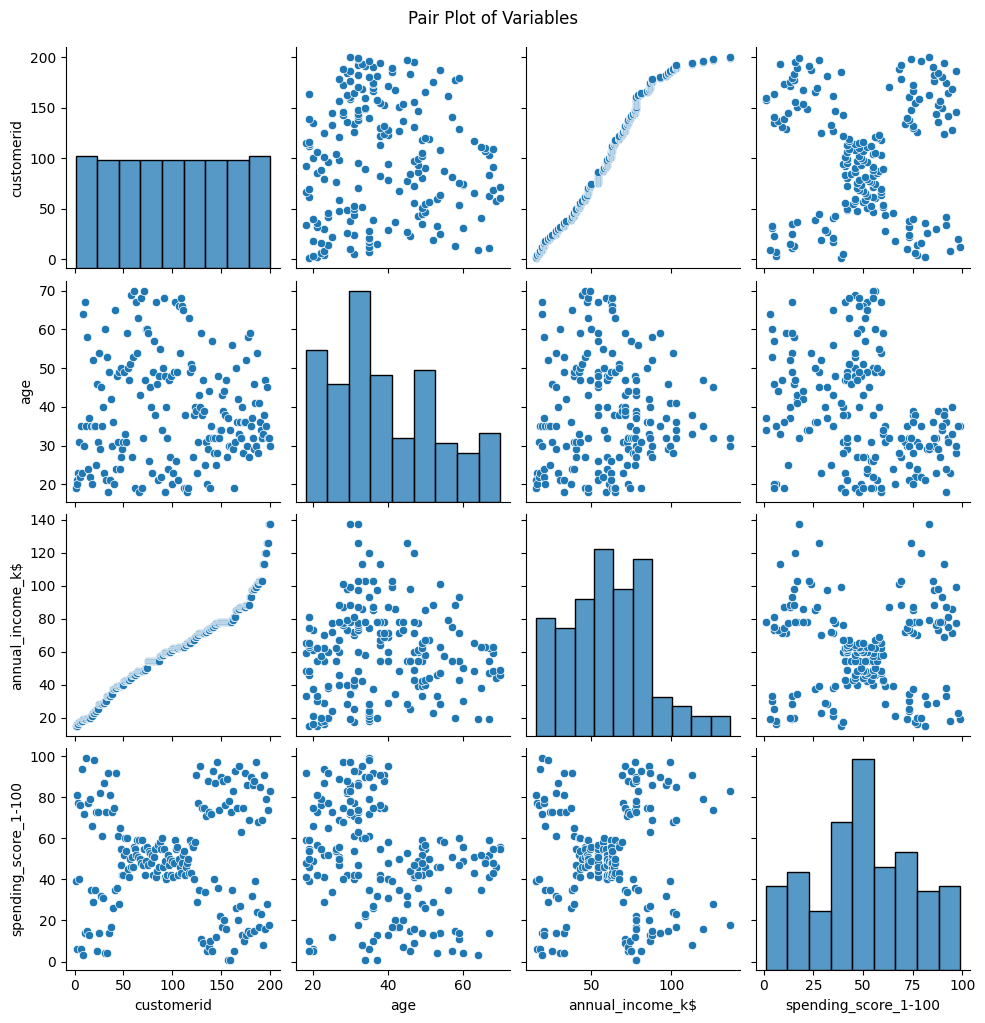

In [ ]:
# tracer un pairplot
sns.pairplot(customer_data)
plt.suptitle("Pair Plot of Variables", y=1.02)
plt.show()

## Connaissance : Observations sur la formation des clusters

### Formation des clusters
- Les paires `customerid`/`spending_score_1-100` et `spending_score_1-100`/`annual_income_k` forment **cinq clusters distincts** avec des positions similaires.
- Cette distribution pourrait s'expliquer par :
  - **Différentes périodes d'acquisition** des clients
  - Une **tendance économique croissante** (les clients plus récents, avec des `customerid` plus élevés, ont des revenus annuels (`annual_income_k`) plus importants mais des scores de dépenses (`spending_score_1-100`) similaires)

> **Remarque** :  
> `customerid` étant un simple identifiant, il doit être exclu des caractéristiques utilisées pour le clustering.

---

### Distribution des données (après suppression de `customerid`)
- **Asymétrie à droite** :  
  `age` et `annual_income_k`
- **Distribution normale** :  
  `spending_score_1_100` (à confirmer par test de normalité)

---

### Relation entre l'âge et les autres caractéristiques
- Aucune **relation claire** entre l'âge et les autres variables numériques.
- **Piste d'amélioration** :  
  Convertir l'âge en variable catégorielle (tranches d'âge).

---

### Test de normalité de D'Agostino
- **Principe** :  
  Prend en compte l'aplatissement (kurtosis) pour évaluer la normalité.
- **Hypothèses** :  
  - H0 : Les données suivent une distribution normale  
  - H1 : Distribution non normale  
- **Critère** :  
  Rejet de H0 si **p-value < 0.05**.

In [ ]:
# Créer une fonction de test de normalité D'Agostino
def test_dagostino(var):
    """
    Effectue le test de normalité D'Agostino sur une variable
    Affiche la statistique du test et la p-value
    Interprète le résultat selon le seuil de signification de 5%
    """
    stat, p_value = stats.normaltest(var)
    print(f"Statistique : {stat}, p-value : {p_value}")
    if p_value < 0.05:
        print("Les données ne suivent pas une distribution normale (rejet de H0).")
    else:
        print("Les données suivent une distribution normale (on ne rejette pas H0).")

# Exécuter le test de D'Agostino pour chaque variable numérique
for colonne in customer_data.columns:
    if colonne != 'gender':  # On saute la variable catégorielle 'genre'
        print(f"\nTest de normalité pour la variable {colonne}:")
        test_dagostino(customer_data[colonne])
    else:
        continue  # Passe à l'itération suivante


Test de normalité pour la variable customerid:
Statistique : 93.37783184830445, p-value : 5.287634750219395e-21
Les données ne suivent pas une distribution normale (rejet de H0).

Test de normalité pour la variable age:
Statistique : 15.577514003752057, p-value : 0.00041436762218018195
Les données ne suivent pas une distribution normale (rejet de H0).

Test de normalité pour la variable annual_income_k$:
Statistique : 3.5109953115353187, p-value : 0.1728212154129815
Les données suivent une distribution normale (on ne rejette pas H0).

Test de normalité pour la variable spending_score_1-100:
Statistique : 16.302230221326983, p-value : 0.0002884135672001835
Les données ne suivent pas une distribution normale (rejet de H0).


**Conclusion du test de normalité** :

 `annual_income_k` : p-value = 0.173 > 0.05 → Distribution normale  
 Autres variables numériques : Distributions non normales (p-value < 0.05)

## b. Gender vs. Variables numériques

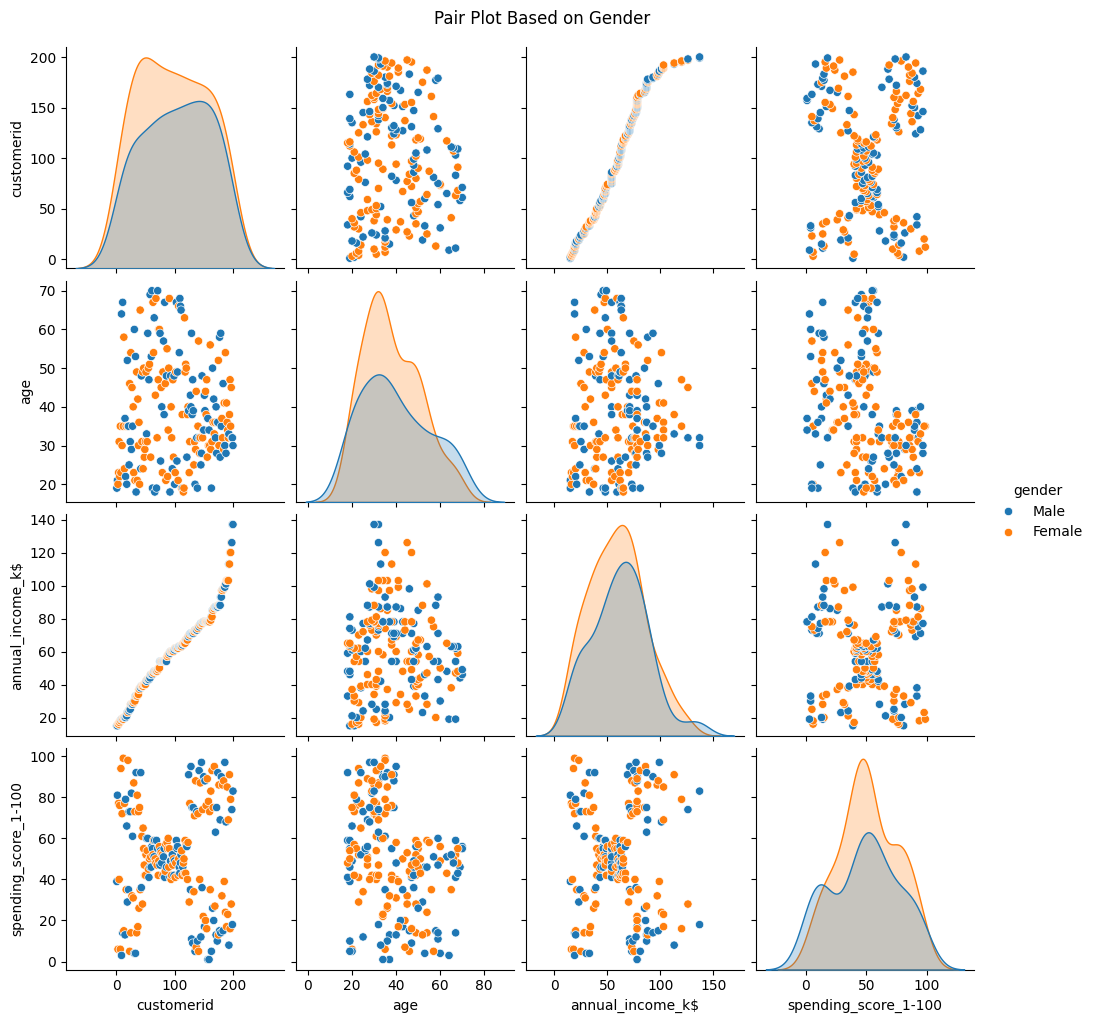

In [ ]:
# faire pairplot
sns.pairplot(customer_data,hue='gender')
plt.suptitle("Pair Plot Based on Gender", y=1.02)
plt.show()

### Connaissance :

* D'après les pairplots, on observe que les deux genres présentent des
  caractéristiques similaires pour chaque relation entre variables numériques analysées.  

* Autrement dit, le genre n'influence pas significativement l'âge, le revenu
 annuel ou le score de dépenses des clients du centre commercial.
   
* Nous pouvons le confirmer avec un test de Mann-Whitney U.

In [ ]:
# Créer une fonction pour séparer les groupes par genre pour chaque variable numérique
def tests_whitney(data):
    """
    Effectue des tests de Mann-Whitney U pour comparer les distributions
    entre hommes et femmes pour chaque caractéristique numérique.
    """
    liste_colonnes = data.columns
    for colonne in liste_colonnes:
        # Exclure la colonne 'genre'
        if colonne != 'gender':
            donnees_hommes = data[data['gender'] == 'Male'][colonne]
            donnees_femmes = data[data['gender'] == 'Female'][colonne]

            # Effectuer le test de Mann-Whitney U
            statistique, p_value = stats.mannwhitneyu(donnees_hommes, donnees_femmes)

            # Titre
            print(f"Résultats du test de Mann-Whitney U pour Genre vs {colonne.capitalize()}")

            # Afficher les résultats
            print(f"Statistique U : {statistique}, p-value : {p_value}")

            # Interprétation
            alpha = 0.05
            if p_value < alpha:
                print("On rejette l'hypothèse nulle : Il y a une différence significative entre les groupes.")
            else:
                print("On ne rejette pas l'hypothèse nulle : Aucune différence significative entre les groupes.")
            print("")
        else:
            continue  # Passer pour la colonne 'gender'

In [ ]:
tests_whitney(customer_data)

Résultats du test de Mann-Whitney U pour Genre vs Customerid
Statistique U : 5257.0, p-value : 0.4188053807494342
On ne rejette pas l'hypothèse nulle : Aucune différence significative entre les groupes.

Résultats du test de Mann-Whitney U pour Genre vs Age
Statistique U : 5127.5, p-value : 0.6241559040716951
On ne rejette pas l'hypothèse nulle : Aucune différence significative entre les groupes.

Résultats du test de Mann-Whitney U pour Genre vs Annual_income_k$
Statistique U : 5260.0, p-value : 0.41440053689269707
On ne rejette pas l'hypothèse nulle : Aucune différence significative entre les groupes.

Résultats du test de Mann-Whitney U pour Genre vs Spending_score_1-100
Statistique U : 4697.5, p-value : 0.5712794188160656
On ne rejette pas l'hypothèse nulle : Aucune différence significative entre les groupes.



### Connaissance :


*   Le test de Mann-Whitney U a démontré qu'**aucune variable** n'entretient
de  relation significative avec le "Gender".  
*   Nous pouvons expérimenter l'**effet de l'inclusion du genre** dans le processus de clustering.




# **5. Ingénierie des caractéristiques (Feature Engineering)**

Nous allons créer **5 expérimentations** en combinant différentes approches :

### Combinaisons à tester (4 configurations) :
1. **Age comme variable** :
   - [ ] Continue
   - [ ] Catégorielle (age_group)

2. **Genre** :
   - [ ] Avec la variable `Gender`
   - [ ] Sans la variable `Gender`

3. **Cluster de contrôle** :
   - Comparaison avec un clustering basé uniquement sur :
     - `spending_score_1-100`
     - `annual_income_k`

### **Prétraitement des données :**
- **Standardisation** (Standard Scaling) pour les variables numériques
- **Encodage One-Hot** pour les variables catégorielles (`age_group` si applicable)

> **Objectif** : Évaluer l'impact de chaque choix sur la qualité des clusters.

In [ ]:
# Avant toute modification, créons une copie du dataset
# Supprimons 'customerid' et créons la variable 'age_group'
modeling_data = customer_data.copy()
modeling_data = modeling_data.drop(columns=['customerid'])

# Création des bins pour les catégories d'âge :
# jeune, population active, âge moyen, retraité
bins = [0, 20, 40, 60, 100]
labels = ['jeune', 'actif', 'âge_moyen', 'retraité']  # Libellés des catégories

# Création de la colonne 'age_group'
modeling_data['age_group'] = pd.cut(modeling_data['age'],
                                  bins=bins,
                                  labels=labels,
                                  right=False)

# Affichage des premières lignes
modeling_data.head()

,gender,age,annual_income_k$,spending_score_1-100,age_group
0,Male,19,15,39,jeune
1,Male,21,15,81,actif
2,Female,20,16,6,actif
3,Female,23,16,77,actif
4,Female,31,17,40,actif


In [ ]:
# Créer une fonction de prétraitement des données
def preprocess_func(df):
    """
    Prétraite un DataFrame en :
    1. Standardisant les variables numériques
    2. Encodant les variables catégorielles en one-hot
    Retourne le préprocesseur, les données transformées et un DataFrame
    """
    # Sélection des colonnes par type
    numeric_features = df.select_dtypes(include='number').columns.tolist()
    cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Initialisation des transformations
    transformers  = [('num', StandardScaler(),  numeric_features)]

    # Ajout conditionnel de l'encodeur one-hot
    if cat_features:
        transformers .append(('cat', OneHotEncoder(drop='first', sparse_output=False),
                             cat_features))

    # Création du ColumnTransformer
    preprocessor = ColumnTransformer(transformers)

    # Application des transformations
    X_transformed = preprocessor.fit_transform(df)

    # Récupération des noms de features
    feature_names = numeric_features.copy()

    # Ajout des noms des colonnes one-hot si nécessaire
    if cat_features:
        ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
        feature_names += list(ohe_columns)

    # Création du DataFrame transformé
    df_scaled_encoded = pd.DataFrame(X_transformed, columns=feature_names)

    return preprocessor, X_transformed, df_scaled_encoded

## **a. Expérimentation Set 1 :**
*Age + Gender*

In [ ]:
# Conserver un jeu de données séparé (sans les groupes d'âge)
set_1 = modeling_data.drop(columns=['age_group'])

# Afficher les premiers résultats
set_1.head()

,gender,age,annual_income_k$,spending_score_1-100
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [ ]:
# Obtenir les résultats de la fonction de prétraitement
preprocessor_1, X_transformed_1, transformed_df_1 = preprocess_func(set_1)

# Afficher les premiers résultats
transformed_df_1.head()

,age,annual_income_k$,spending_score_1-100,gender_Male
0,-1.424569,-1.738999,-0.434801,1.0
1,-1.281035,-1.738999,1.195704,1.0
2,-1.352802,-1.700830,-1.715913,0.0
3,-1.137502,-1.700830,1.040418,0.0
4,-0.563369,-1.662660,-0.395980,0.0


## **b. Expérimentation Set 2 :**
*Age + sans Gender*

In [ ]:
# conserver un dataset sans le gender et le age_group
set_2 = modeling_data.drop(columns=['gender','age_group'])

# afficher résulat
set_2.head()

,age,annual_income_k$,spending_score_1-100
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [ ]:
# obtenir les résultats à partir de fonction
preprocessor_2, X_transformed_2, transformed_df_2 = preprocess_func(set_2)

# afficher résultat
transformed_df_2.head()

,age,annual_income_k$,spending_score_1-100
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## **c. Expérimentation Set 3 :**
*age_group + gender*

In [ ]:
set_3 = modeling_data.drop(columns=['age'])

set_3.head()

,gender,annual_income_k$,spending_score_1-100,age_group
0,Male,15,39,jeune
1,Male,15,81,actif
2,Female,16,6,actif
3,Female,16,77,actif
4,Female,17,40,actif


In [ ]:
set_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gender                200 non-null    object  
 1   annual_income_k$      200 non-null    int64   
 2   spending_score_1-100  200 non-null    int64   
 3   age_group             200 non-null    category
dtypes: category(1), int64(2), object(1)
memory usage: 5.2+ KB


In [ ]:
preprocessor_3, X_transformed_3, transformed_df_3 = preprocess_func(set_3)

transformed_df_3.head()

,annual_income_k$,spending_score_1-100,gender_Male,age_group_jeune,age_group_retraité,age_group_âge_moyen
0,-1.738999,-0.434801,1.0,1.0,0.0,0.0
1,-1.738999,1.195704,1.0,0.0,0.0,0.0
2,-1.700830,-1.715913,0.0,0.0,0.0,0.0
3,-1.700830,1.040418,0.0,0.0,0.0,0.0
4,-1.662660,-0.395980,0.0,0.0,0.0,0.0


## **d. Expérimentation Set 4 :**
*age_group + sans gender*

In [ ]:
set_4 = modeling_data.drop(columns=['age','gender'])

set_4.head()

,annual_income_k$,spending_score_1-100,age_group
0,15,39,jeune
1,15,81,actif
2,16,6,actif
3,16,77,actif
4,17,40,actif


In [ ]:
preprocessor_4, X_transformed_4, transformed_df_4 = preprocess_func(set_4)

transformed_df_4.head()

,annual_income_k$,spending_score_1-100,age_group_jeune,age_group_retraité,age_group_âge_moyen
0,-1.738999,-0.434801,1.0,0.0,0.0
1,-1.738999,1.195704,0.0,0.0,0.0
2,-1.700830,-1.715913,0.0,0.0,0.0
3,-1.700830,1.040418,0.0,0.0,0.0
4,-1.662660,-0.395980,0.0,0.0,0.0


### **e. Expérimentation Set 5 : (controle)**
*seulement  spending score et annual income*

In [ ]:
set_5 = modeling_data.drop(columns=['age','gender','age_group'])

set_5.head()

,annual_income_k$,spending_score_1-100
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [ ]:
preprocessor_5, X_transformed_5, transformed_df_5 = preprocess_func(set_5)

transformed_df_5.head()

,annual_income_k$,spending_score_1-100
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


# **6. Modélisation**
Options d'algorithmes de clustering :

a. **K-Means** : Simple et facile à interpréter avec l'hypothèse de clusters sphériques. Fonctionne mieux avec des données numériques, mais le genre peut être transformé avec un encodage one-hot.

b. **DBScan** : Adapté lorsque vous attendez des clusters de tailles et formes variées.

c. **Gaussian Mixture Model** : Approprié lorsque les caractéristiques ont des distributions différentes. C'est une approche de modélisation probabiliste.

### a. Méthode du Coude pour la Valeur k Optimale
**Métrique** : Somme des carrés intra-cluster (WCSS - Within Cluster Sum of Squares)

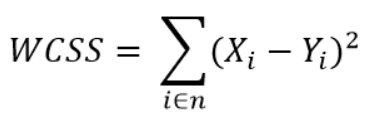

Où :
- `k` = nombre de clusters
- `n_i` = nombre de points dans le cluster (i)
- `x_j` = point de données (j) dans le cluster (i)
- `c_i` = centroïde du cluster (i)

Un WCSS plus petit implique des clusters plus denses et bien définis. Nous devons trouver la valeur k où le changement de WCSS diminue significativement.


**Set 1**

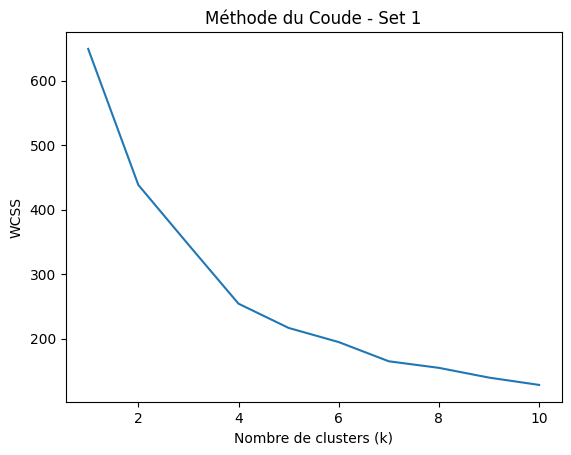

In [ ]:
# Méthode du coude pour trouver un k optimal
wcss = []
for k in range(1, 11):  # Ajuster l'intervalle selon les besoins
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(transformed_df_1)
    wcss.append(kmeans.inertia_)  # L'inertie dans K-Means = WCSS

plt.plot(range(1, 11), wcss)
plt.title('Méthode du Coude - Set 1')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS')
plt.show()

Le point de coude, où le WCSS ne diminue plus significativement lorsque k augmente, est à k = 5.



**Set 2**

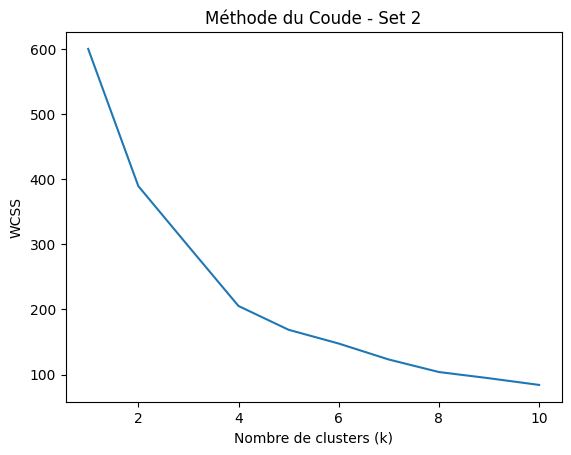

In [ ]:
# Méthode du coude pour trouver un k optimal
wcss = []
for k in range(1, 11):  # Ajuster l'intervalle selon les besoins
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(transformed_df_2)
    wcss.append(kmeans.inertia_)  # L'inertie dans K-Means = WCSS

plt.plot(range(1, 11), wcss)
plt.title('Méthode du Coude - Set 2')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS')
plt.show()

Le point de coude, où le WCSS ne diminue plus significativement lorsque k augmente, est à k = 5.




**Set 3**

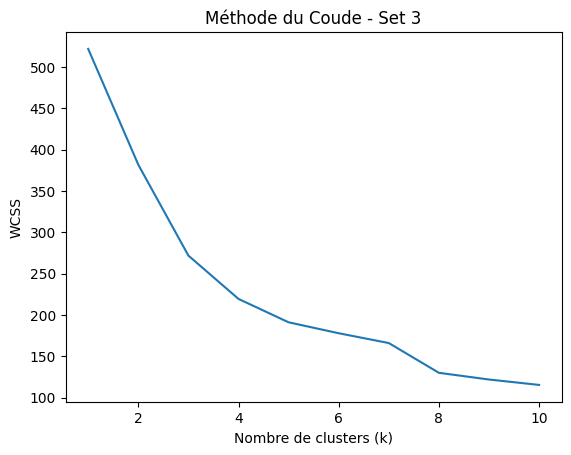

In [ ]:
# Méthode du coude pour trouver un k optimal
wcss = []
for k in range(1, 11):  # Ajuster l'intervalle selon les besoins
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(transformed_df_3)
    wcss.append(kmeans.inertia_)  # L'inertie dans K-Means = WCSS

plt.plot(range(1, 11), wcss)
plt.title('Méthode du Coude - Set 3')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS')
plt.show()

Le point de coude, où le WCSS ne diminue plus significativement lorsque k augmente, est à k = 4.

**Set 4**

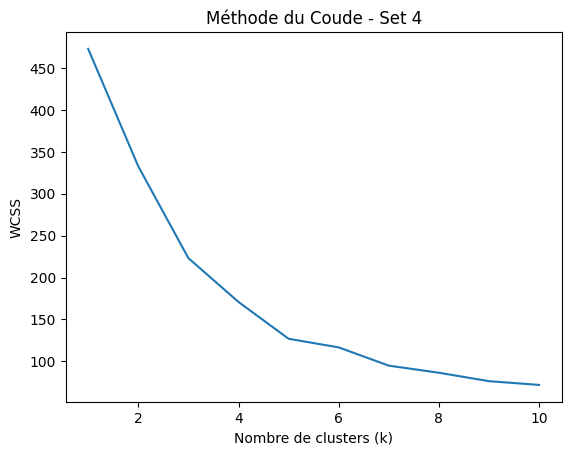

In [ ]:
# Méthode du coude pour trouver un k optimal
wcss = []
for k in range(1, 11):  # Ajuster l'intervalle selon les besoins
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(transformed_df_4)
    wcss.append(kmeans.inertia_)  # L'inertie dans K-Means = WCSS

plt.plot(range(1, 11), wcss)
plt.title('Méthode du Coude - Set 4')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS')
plt.show()

Le point de coude, où le WCSS ne diminue plus significativement lorsque k augmente, est à k = 5.


**Set 5**

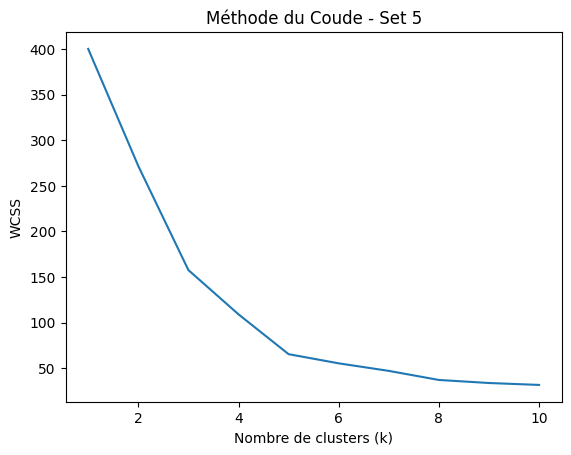

In [ ]:
# Méthode du coude pour trouver un k optimal
wcss = []
for k in range(1, 11):  # Ajuster l'intervalle selon les besoins
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(transformed_df_5)
    wcss.append(kmeans.inertia_)  # L'inertie dans K-Means = WCSS

plt.plot(range(1, 11), wcss)
plt.title('Méthode du Coude - Set 5')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS')
plt.show()

Le point de coude, où le WCSS ne diminue plus significativement lorsque k augmente, est à k = 5.



### b. Processus de Modélisation Final

Set 1

K-means

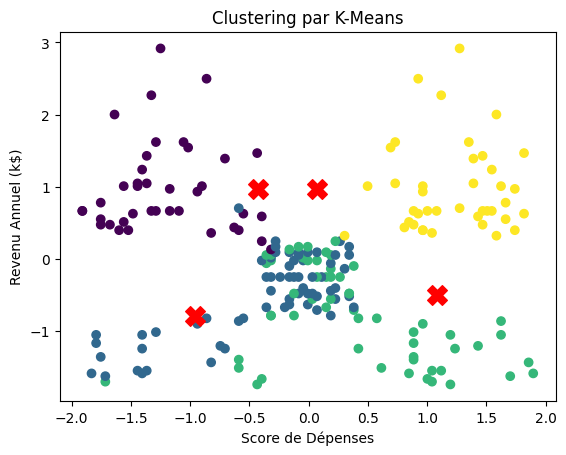

In [ ]:
# Configuration du modèle
kmeans_1 = KMeans(n_clusters=4,random_state=10)

# Entraînement du modèle
kmeans_1.fit(transformed_df_1)

# Étiquettes prédites
kmeans_labels_1 = kmeans_1.labels_

# Visualisation des résultats pour K-Means
plt.scatter(transformed_df_1['spending_score_1-100'], transformed_df_1['annual_income_k$'], c=kmeans_labels_1, cmap='viridis')
plt.scatter(kmeans_1.cluster_centers_[:, 0], kmeans_1.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('Clustering par K-Means')
plt.xlabel('Score de Dépenses')
plt.ylabel('Revenu Annuel (k$)')
plt.show()

DBSCAN

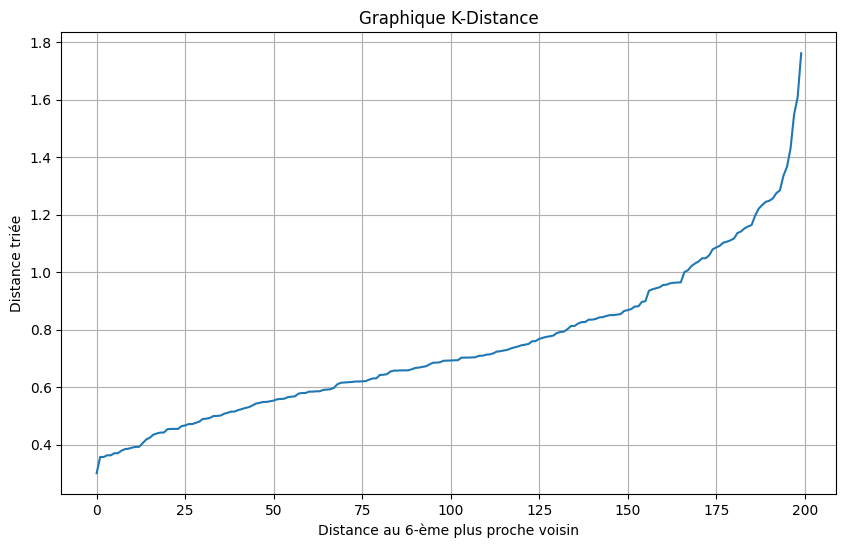

In [ ]:
# Pour trouver un epsilon optimal, utilisons un graphique k-distance
k = 6
# Entraînement du modèle NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(transformed_df_1)
distances, indices = nbrs.kneighbors(transformed_df_1)

# Récupération des distances au k-ème plus proche voisin
k_distance = distances[:, k-1]

# Tri des distances
k_distance_sorted = np.sort(k_distance)

# Création du graphique k-distance
plt.figure(figsize=(10, 6))
plt.plot(k_distance_sorted)
plt.title('Graphique K-Distance')
plt.xlabel(f'Distance au {k}-ème plus proche voisin')
plt.ylabel('Distance triée')
plt.grid(True)
plt.show()

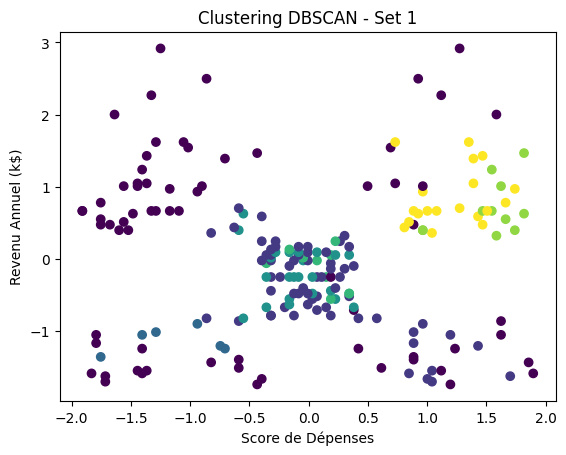

In [ ]:
# Configuration du modèle
dbscan_1 = DBSCAN(min_samples=7, eps=0.7)
dbscan_1.fit(transformed_df_1)

# Récupération des labels
dbscan_labels_1 = dbscan_1.labels_

# Visualisation des résultats pour DBSCAN
plt.scatter(transformed_df_1['spending_score_1-100'], transformed_df_1['annual_income_k$'], c=dbscan_labels_1, cmap='viridis')
plt.title('Clustering DBSCAN - Set 1')
plt.xlabel('Score de Dépenses')
plt.ylabel('Revenu Annuel (k$)')
plt.show()

GMM

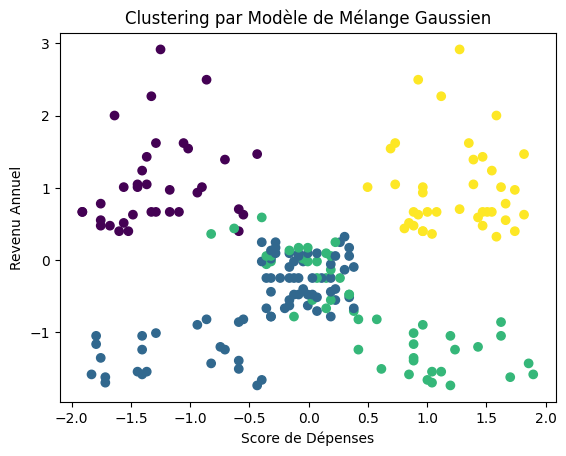

In [ ]:
# Clustering GMM
gmm_1 = GaussianMixture(n_components=4, random_state=10)
gmm_1.fit(transformed_df_1)

# Prédictions
gmm_labels_1 = gmm_1.predict(transformed_df_1)

# Visualisation des résultats pour GMM
plt.scatter(transformed_df_1['spending_score_1-100'], transformed_df_1['annual_income_k$'], c=gmm_labels_1, cmap='viridis')
plt.title('Clustering par Modèle de Mélange Gaussien')
plt.xlabel('Score de Dépenses')
plt.ylabel('Revenu Annuel')
plt.show()

Set 2

K-means

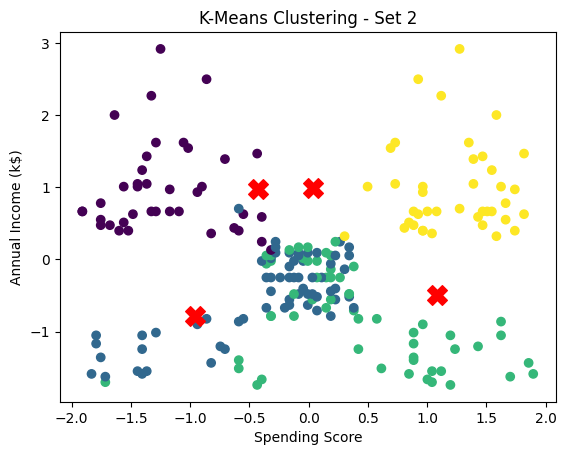

In [ ]:
kmeans_2 = KMeans(n_clusters=4,random_state=10)

kmeans_2.fit(transformed_df_2)

kmeans_labels_2 = kmeans_1.labels_

plt.scatter(transformed_df_2['spending_score_1-100'], transformed_df_2['annual_income_k$'], c=kmeans_labels_2, cmap='viridis')
plt.scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 2')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

DBSCAN

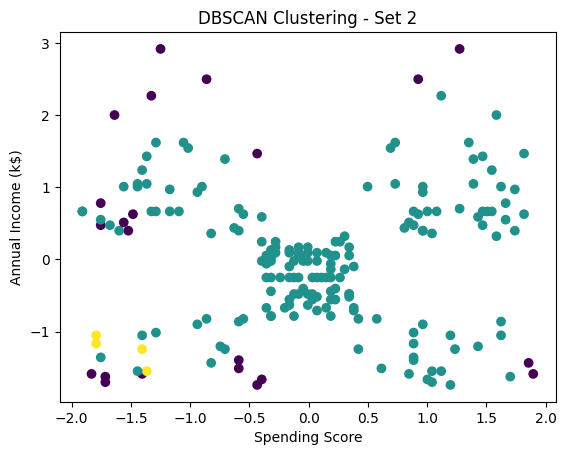

In [ ]:
dbscan_2 = DBSCAN(min_samples=7,eps=0.7)
dbscan_2.fit(transformed_df_2)

dbscan_labels_2 = dbscan_2.labels_

plt.scatter(transformed_df_2['spending_score_1-100'], transformed_df_2['annual_income_k$'], c=dbscan_labels_2, cmap='viridis')
plt.title('DBSCAN Clustering - Set 2')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

GMM

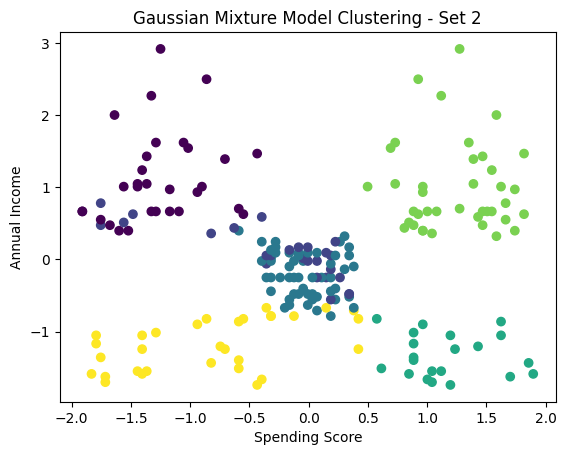

In [ ]:
gmm_2 = GaussianMixture(n_components=6, random_state=10)
gmm_2.fit(transformed_df_2)

gmm_labels_2 = gmm_2.predict(transformed_df_2)

plt.scatter(transformed_df_2['spending_score_1-100'], transformed_df_2['annual_income_k$'], c=gmm_labels_2, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 2')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

Set 3

K-means

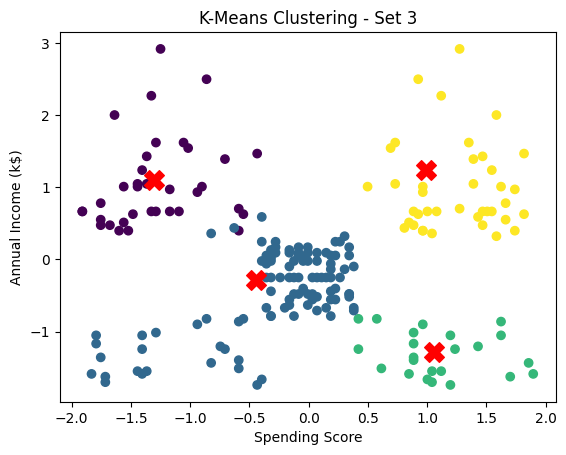

In [ ]:
kmeans_3 = KMeans(n_clusters=4,random_state=10)

kmeans_3.fit(transformed_df_3)

kmeans_labels_3 = kmeans_3.labels_

plt.scatter(transformed_df_3['spending_score_1-100'], transformed_df_3['annual_income_k$'], c=kmeans_labels_3, cmap='viridis')
plt.scatter(kmeans_3.cluster_centers_[:, 0], kmeans_3.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 3')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

DBSCAN

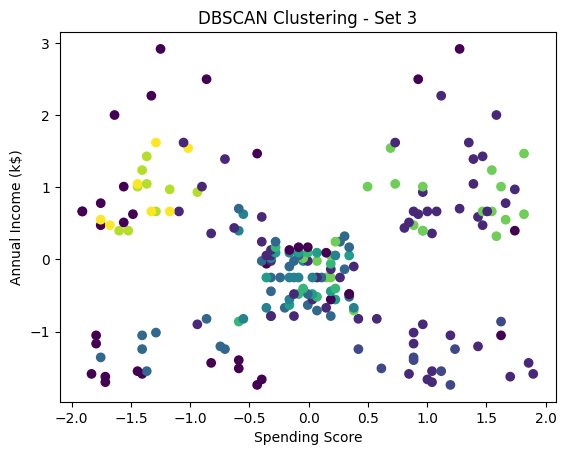

In [ ]:
dbscan_3 = DBSCAN(min_samples=7,eps=0.7)
dbscan_3.fit(transformed_df_3)

dbscan_labels_3 = dbscan_3.labels_

plt.scatter(transformed_df_3['spending_score_1-100'], transformed_df_3['annual_income_k$'], c=dbscan_labels_3, cmap='viridis')
plt.title('DBSCAN Clustering - Set 3')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

GMM

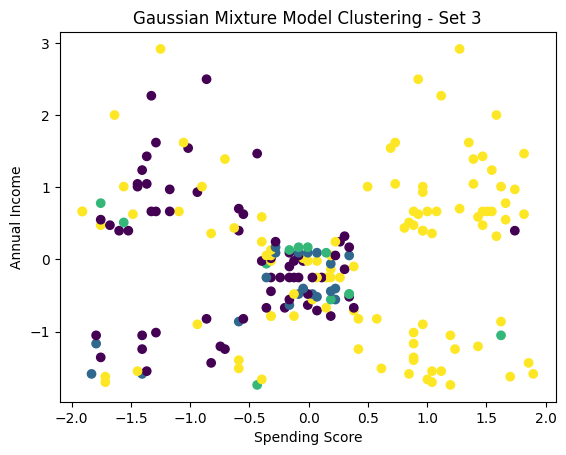

In [ ]:
gmm_3 = GaussianMixture(n_components=4, random_state=10)
gmm_3.fit(transformed_df_3)

gmm_labels_3 = gmm_3.predict(transformed_df_3)

plt.scatter(transformed_df_3['spending_score_1-100'], transformed_df_3['annual_income_k$'], c=gmm_labels_3, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 3')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

Set 4

K-means

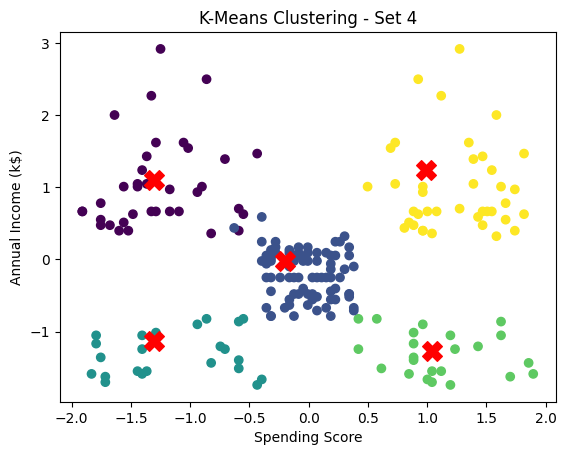

In [ ]:
kmeans_4 = KMeans(n_clusters=5,random_state=10)

kmeans_4.fit(transformed_df_4)

kmeans_labels_4 = kmeans_4.labels_

plt.scatter(transformed_df_4['spending_score_1-100'], transformed_df_4['annual_income_k$'], c=kmeans_labels_4, cmap='viridis')
plt.scatter(kmeans_4.cluster_centers_[:, 0], kmeans_4.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 4')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

DBSCAN

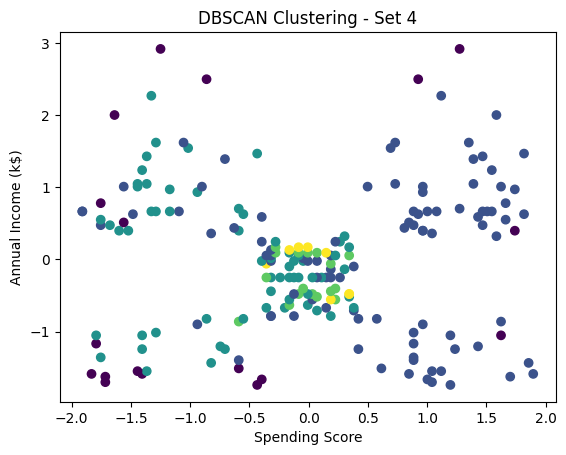

In [ ]:
dbscan_4 = DBSCAN(min_samples=7,eps=0.7)
dbscan_4.fit(transformed_df_4)

dbscan_labels_4 = dbscan_4.labels_

plt.scatter(transformed_df_4['spending_score_1-100'], transformed_df_4['annual_income_k$'], c=dbscan_labels_4, cmap='viridis')
plt.title('DBSCAN Clustering - Set 4')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

GMM

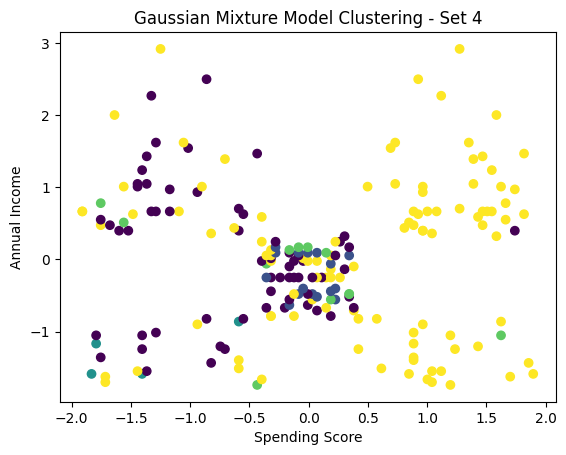

In [ ]:
gmm_4 = GaussianMixture(n_components=5, random_state=10)
gmm_4.fit(transformed_df_4)

gmm_labels_4 = gmm_4.predict(transformed_df_4)

plt.scatter(transformed_df_4['spending_score_1-100'], transformed_df_4['annual_income_k$'], c=gmm_labels_4, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 4')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

Set 5

K-means

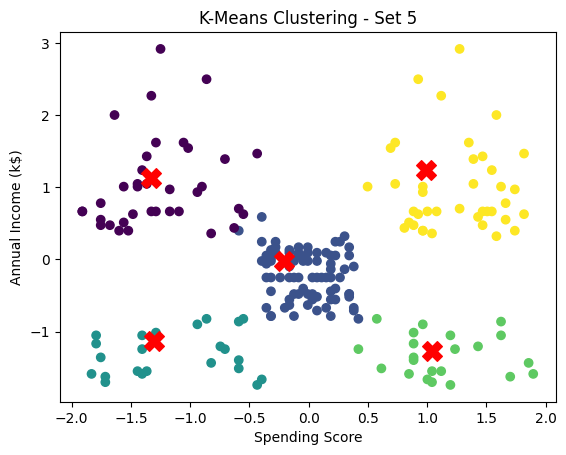

In [ ]:
kmeans_5 = KMeans(n_clusters=5,random_state=10)

kmeans_5.fit(transformed_df_5)

kmeans_labels_5 = kmeans_5.labels_

plt.scatter(transformed_df_5['spending_score_1-100'], transformed_df_5['annual_income_k$'], c=kmeans_labels_5, cmap='viridis')
plt.scatter(kmeans_5.cluster_centers_[:, 0], kmeans_5.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 5')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()


DBSCAN

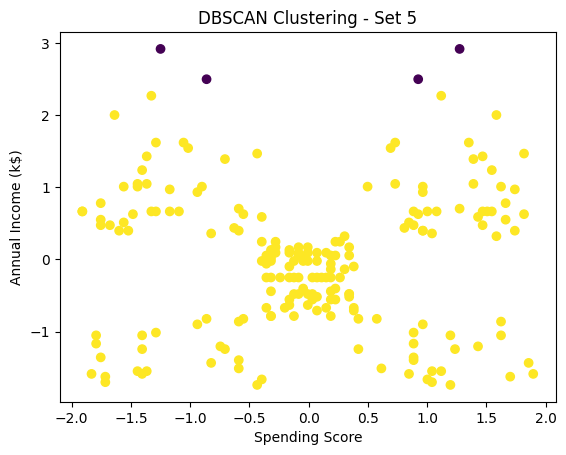

In [ ]:
dbscan_5 = DBSCAN(min_samples=7,eps=0.7)
dbscan_5.fit(transformed_df_5)

dbscan_labels_5 = dbscan_5.labels_

plt.scatter(transformed_df_5['spending_score_1-100'], transformed_df_5['annual_income_k$'], c=dbscan_labels_5, cmap='viridis')
plt.title('DBSCAN Clustering - Set 5')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

GMM

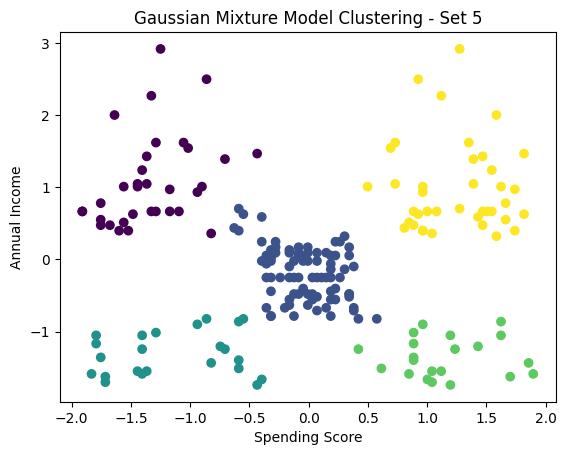

In [ ]:
gmm_5 = GaussianMixture(n_components=5, random_state=10)
gmm_5.fit(transformed_df_5)

gmm_labels_5 = gmm_5.predict(transformed_df_5)

plt.scatter(transformed_df_5['spending_score_1-100'], transformed_df_5['annual_income_k$'], c=gmm_labels_5, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 5')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

# **7. Évaluation des Modèles**
Métriques d'évaluation disponibles :

#### a. Silhouette-score  
Mesure la similarité d'un point avec son cluster par rapport aux autres clusters.  

- **Plage de valeurs** : de -1 à +1  
- **Interprétation** :  
  - Proche de +1 : clusters bien séparés  
  - Proche de 0 : chevauchement entre clusters  
  - Proche de -1 : mauvais regroupement  

#### b. Indice de Davies-Bouldin  
Mesure le ratio entre :  
- Distance intra-cluster (compacité)  
- Distance inter-clusters (séparation)  

- **Critère** : Plus la valeur est faible, meilleur est le clustering  
- **Signification** :  
  - Intra-cluster : similarité interne (plus c'est petit, plus le cluster est dense)  
  - Inter-clusters : différenciation externe (plus c'est grand, plus les clusters sont distincts)  

> *Note technique* :  
> Ces métriques sont calculées sur les données standardisées pour une comparaison équitable.

## a. Silhouette-score

In [ ]:
def calculate_silhouette_scores(datasets, labels_dict):
    """
    Calcule les scores de silhouette pour plusieurs jeux de données et modèles.

    Paramètres :
    datasets : dict
        Dictionnaire où les clés sont les noms des jeux de données et les valeurs sont les DataFrames.
    labels_dict : dict
        Dictionnaire où les clés sont les noms des modèles et les valeurs sont des dictionnaires
        associant les noms de jeux de données aux labels de clusters.

    Retourne :
    pd.DataFrame : DataFrame contenant les scores de silhouette pour chaque modèle et jeu de données.
    """
    results = {}

    # Parcours des jeux de données
    for dataset_name, dataset in datasets.items():
        results[dataset_name] = {}
        # Parcours de chaque type de modèle
        for model_name, model_labels in labels_dict.items():
            # Récupération des labels pour le jeu de données courant
            labels = model_labels.get(dataset_name)
            if labels is not None:
                # Calcul du score de silhouette
                if len(set(labels)) > 1:  # Au moins 2 clusters requis
                    score = silhouette_score(dataset, labels)
                else:
                    score = -1  # Non applicable pour un seul cluster

                results[dataset_name][model_name] = score
            else:
                results[dataset_name][model_name] = None

    # Création d'un DataFrame à partir des résultats
    silhouette_scores_df = pd.DataFrame(results)
    return silhouette_scores_df

In [ ]:
# Jeux de données prétraités (à remplacer par vos jeux de données réels)
datasets = {
    'Dataset_1': transformed_df_1,  # Données du premier scénario de prétraitement
    'Dataset_2': transformed_df_2,  # Données du deuxième scénario
    'Dataset_3': transformed_df_3,  # Données du troisième scénario
    'Dataset_4': transformed_df_4,  # Données du quatrième scénario
    'Dataset_5': transformed_df_5,  # Données du cinquième scénario
}

# Labels des modèles (à remplacer par vos labels réels)
labels_dict = {
    'K-Means': {  # Résultats du clustering K-Means
        'Dataset_1': kmeans_labels_1,  # Labels pour le dataset 1
        'Dataset_2': kmeans_labels_2,  # Labels pour le dataset 2
        'Dataset_3': kmeans_labels_3,  # Labels pour le dataset 3
        'Dataset_4': kmeans_labels_4,  # Labels pour le dataset 4
        'Dataset_5': kmeans_labels_5,  # Labels pour le dataset 5
    },
    'DBSCAN': {  # Résultats du clustering DBSCAN
        'Dataset_1': dbscan_labels_1,  # Labels DBSCAN dataset 1
        'Dataset_2': dbscan_labels_2,  # Labels DBSCAN dataset 2
        'Dataset_3': dbscan_labels_3,  # Labels DBSCAN dataset 3
        'Dataset_4': dbscan_labels_4,  # Labels DBSCAN dataset 4
        'Dataset_5': dbscan_labels_5,  # Labels DBSCAN dataset 5
    },
    'GMM': {  # Résultats du modèle de mélange gaussien
        'Dataset_1': gmm_labels_1,  # Labels GMM dataset 1
        'Dataset_2': gmm_labels_2,  # Labels GMM dataset 2
        'Dataset_3': gmm_labels_3,  # Labels GMM dataset 3
        'Dataset_4': gmm_labels_4,  # Labels GMM dataset 4
        'Dataset_5': gmm_labels_5,  # Labels GMM dataset 5
    }
}

In [ ]:
silhouette_scores_table = calculate_silhouette_scores(datasets, labels_dict)

silhouette_scores_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5
K-Means,0.350441,0.404161,0.328700,0.423792,0.553942
DBSCAN,0.024478,0.109941,0.091213,0.140783,0.424827
GMM,0.326546,0.392619,0.140706,0.110079,0.553689


Text(0, 0.5, 'Silhouette Score')

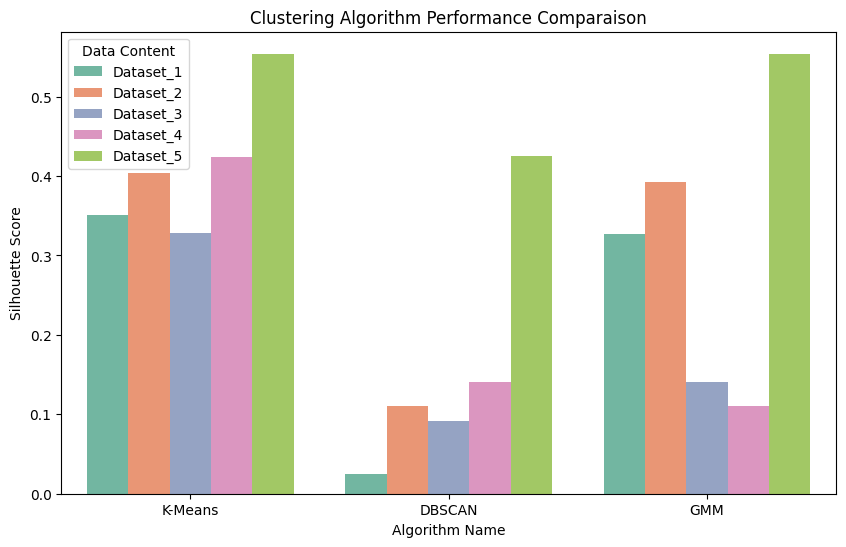

In [ ]:
sill_reset = silhouette_scores_table.reset_index().melt(id_vars='index', var_name='Data Content', value_name='Performance')

plt.figure(figsize=(10, 6))
sns.barplot(data=sill_reset, x='index', y='Performance', hue='Data Content',palette='Set2')
plt.title('Clustering Algorithm Performance Comparaison')
plt.xlabel('Algorithm Name')
plt.ylabel('Silhouette Score')

## b. Indice de Davies-Bouldin

In [ ]:
def calculate_davies_bouldin_indices(datasets, labels_dict):
    """
    Calcule l'indice de Davies-Bouldin pour plusieurs jeux de données et modèles.

    Paramètres :
    datasets : dict
        Dictionnaire où les clés sont les noms des jeux de données et les valeurs sont les DataFrames.
    labels_dict : dict
        Dictionnaire où les clés sont les noms des modèles et les valeurs sont des dictionnaires
        associant les noms de jeux de données aux labels de clusters.

    Retourne :
    pd.DataFrame : DataFrame contenant l'indice de Davies-Bouldin pour chaque modèle et jeu de données.
    """
    results = {}

    # Parcours des jeux de données
    for dataset_name, dataset in datasets.items():
        results[dataset_name] = {}
        # Parcours de chaque type de modèle
        for model_name, model_labels in labels_dict.items():
            # Récupération des labels pour le jeu de données courant
            labels = model_labels.get(dataset_name)
            if labels is not None:
                # Calcul de l'indice de Davies-Bouldin
                if len(set(labels)) > 1:  # Au moins 2 clusters requis
                    db_index = davies_bouldin_score(dataset, labels)
                else:
                    db_index = float('inf')  # Non applicable pour un seul cluster

                results[dataset_name][model_name] = db_index
            else:
                results[dataset_name][model_name] = None

    # Création d'un DataFrame à partir des résultats
    db_index_df = pd.DataFrame(results)
    return db_index_df

In [ ]:
db_index_table = calculate_davies_bouldin_indices(datasets, labels_dict)

db_index_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5
K-Means,1.069270,0.934533,1.071042,0.917096,0.570808
DBSCAN,1.898050,3.080161,1.687168,2.788488,0.816827
GMM,1.128705,0.954088,1.885094,1.531352,0.576010


Text(0, 0.5, 'DB Index')

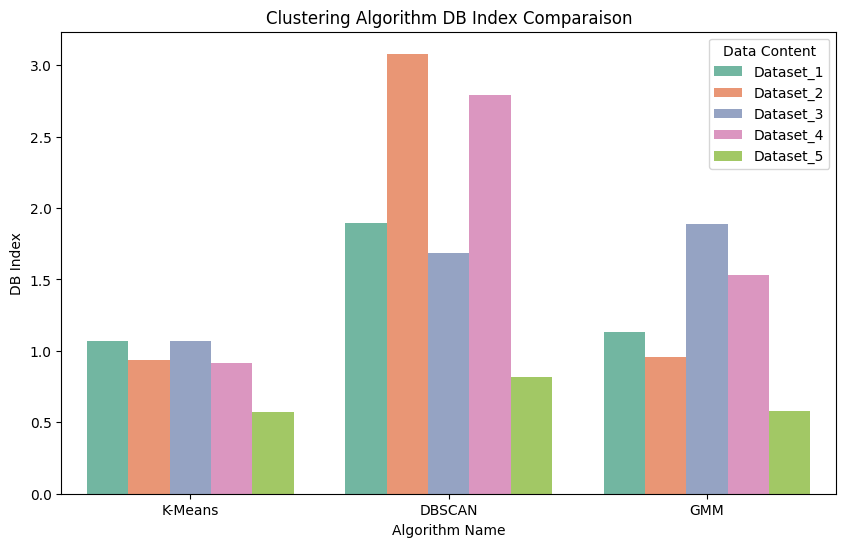

In [ ]:
db_index_reset = db_index_table.reset_index().melt(id_vars='index', var_name='Data Content', value_name='Performance')

plt.figure(figsize=(10, 6))
sns.barplot(data=db_index_reset, x='index', y='Performance', hue='Data Content',palette='Set2')
plt.title('Clustering Algorithm DB Index Comparaison')
plt.xlabel('Algorithm Name')
plt.ylabel('DB Index')

### Connaissance :
L'analyse des résultats pour K-Means, DBSCAN et Gaussian Mixture Model (GMM) sur les cinq expérimentations révèle des différences significatives de performance, comme l'indiquent les Silhouette Scores et Davies-Bouldin Index. Principales observations :

#### **Silhouette Scores** :
- **K-Means** obtient son meilleur score (0.553942) sur `Dataset_5`, suggérant des clusters bien définis, mais avec un jeu de caractéristiques limité.
- `Dataset_4` présente également des performances respectables (score de 0.435224) avec K-Means.

#### **Davies-Bouldin Index** :
- **K-Means** sur `Dataset_4` affiche un index de 0.884750, indiquant une structure de clusters mieux définie que la plupart des autres jeux de données (à l'exception de `Dataset_5` : 0.570808).
- **Avantage clé de `Dataset_4`** :  
  Il intègre des variables plus informatives (`age_group`, `spending_score_1-100`, `annual_income_k$`), permettant une analyse plus riche des caractéristiques des clusters.
- **Limite de `Dataset_5`** :  
  Seules `spending_score_1-100` et `annual_income_k$` sont utilisées, ce qui réduit la profondeur des insights actionnables malgré de meilleures métriques.

#### **Conclusion** :
Le modèle **K-Means appliqué à `Dataset_4`** est retenu comme solution optimale, combinant :
- Une performance métrique satisfaisante  
- Des variables plus interprétables pour la segmentation client  

# **8. Analyse Exploratoire Post-Modélisation**

**vise** à caractériser les clusters résultants

In [ ]:
post_cluster_data = set_4.copy()

# ajouter la colonne cluster
post_cluster_data['cluster'] = kmeans_labels_4

# affiche
post_cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   annual_income_k$      200 non-null    int64   
 1   spending_score_1-100  200 non-null    int64   
 2   age_group             200 non-null    category
 3   cluster               200 non-null    int32   
dtypes: category(1), int32(1), int64(2)
memory usage: 4.4 KB


## a. Median Cluster Profiling

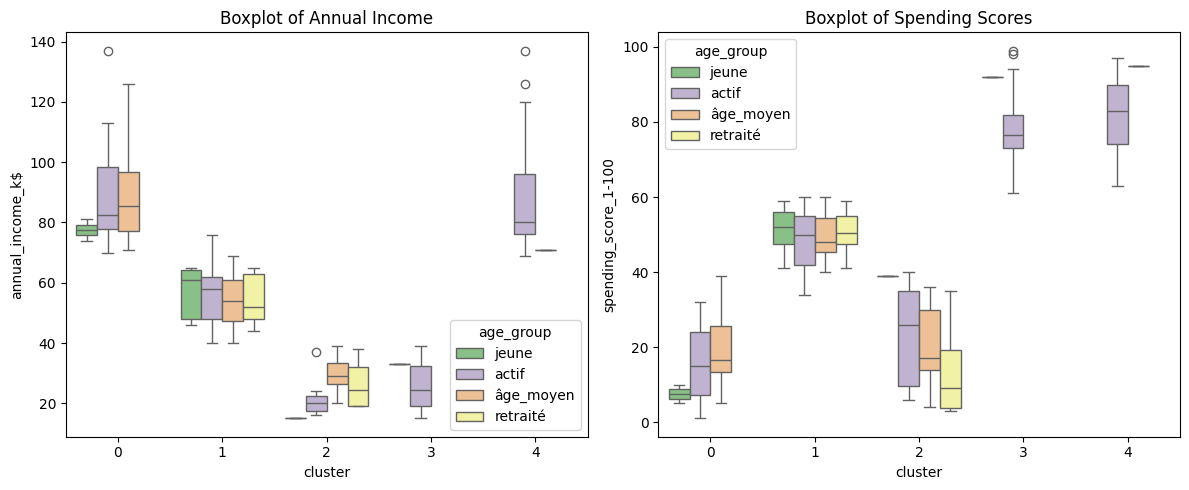

In [ ]:
# Distribution de Income et spending score  par Cluster
fig, axs = plt.subplots(1,2,figsize=(12,5))
# Boxplot pour le Dataset 1
sns.boxplot(x='cluster', y='annual_income_k$', data=post_cluster_data, hue='age_group',palette='Accent', ax=axs[0])
axs[0].set_title('Boxplot of Annual Income')

# Boxplot pour le Dataset 2
sns.boxplot(x='cluster', y='spending_score_1-100', data=post_cluster_data, hue='age_group',palette='Accent', ax=axs[1])
axs[1].set_title('Boxplot of Spending Scores')

# Ajuster layout
plt.tight_layout()

# afficher les plots
plt.show()


### Connaissances :

**Cluster 0** : Revenu médian élevé / faible score de dépenses  
- Profil : Clients non-retraités avec revenus élevés (> 80k$)  
- Comportement : Dépenses faibles (score < 20)  

**Cluster 1** : Seniors aisés / forte consommation  
- Profil : Clients âgés (actifs + âge moyen) avec hauts revenus (> 80k$)  
- Comportement : Forte dépense (score > 80)  

**Cluster 2** : Faible revenu / faible consommation  
- Profil : Clients à bas revenus (< 40k$)  
- Comportement : Dépenses limitées (score < 40)  

**Cluster 3** : Jeunes à faible revenu mais dépensiers  
- Profil : Jeunes (jeune + actifs) avec revenus modestes (< 40k$)  
- Comportement : Dépenses élevées (score > 70)  

**Cluster 4** : Revenu moyen / consommation modérée  
- Profil : Revenus intermédiaires (~60k$)  
- Comportement : Dépenses moyennes (score ~50)

### b. Profils Clients Post-Clustering



1. **Hauts revenus (> 80k$) / Faible dépense (score < 20)**  
   *Note* : Clients prudents dans leurs achats.

2. **Seniors aisés (> 80k$) / Forte dépense (score > 80)**  
   *Note* : Clients prêts à dépenser pour des produits haut de gamme.

3. **Faibles revenus (< 40k$) / Faible dépense (score < 40)**  
   *Note* : Clients axés sur l'essentiel.

4. **Jeunes à faibles revenus (< 40k$) / Dépenses élevées (score > 70)**  
   *Note* : Clients dépensiers malgré des moyens limités.

5. **Revenus moyens (±60k$) / Dépenses modérées (score ±50)**  
   *Note* : Comportement d'achat équilibré.

---

### c. Stratégies de Marketing Ciblé  
*(Suggestions basées sur les profils clients)*  

| Cluster | Stratégies |  
|---------|------------|  
| **1** (Hauts revenus/Prudents) | • Offres personnalisées<br>• Programme de fidélité<br>• Branding premium |  
| **2** (Seniors aisés/Dépensiers) | • Upselling/Cross-selling<br>• Événements VIP<br>• Produits de luxe/exclusifs |  
| **3** (Faibles revenus/Essentiel) | • Promotions valeur<br>• Offres groupées<br>• Programmes de parrainage |  
| **4** (Jeunes/Dépensiers) | • FOMO (offres limitées)<br>• Marketing d'influence<br>• Mise en avant des expériences |  
| **5** (Revenus moyens/Modérés) | • Campagnes ciblées<br>• Programmes de récompenses<br>• Promotions lifestyle |  


# **9. amélioration**

### Recommandation pour Renforcer l'Analyse

Pour **consolider la robustesse** et la **fiabilité** de l'analyse de clustering, il est recommandé de :  

1. **Collecter un échantillon de données plus large**  
   - *Objectif* : Éviter les biais et améliorer la représentativité des clusters.  

2. **Cibler spécifiquement** :  
   - **Jeunes** (clusters 1, 3 et 4) → Vérifier la cohérence de leur classification actuelle.  
   - **Population d'âge moyen** (cluster 2) → Confirmer leur appartenance à ce groupe.  

3. **Bénéfices attendus** :  
   - Validation des profils existants  
   - Détection d'éventuels chevauchements entre clusters  
   - Optimisation des stratégies marketing ciblées  
